In [1]:
import mne
import os
import glob
import numpy as np
import pandas as pd
from scipy.io import savemat, loadmat
import matplotlib.pyplot as plt
import pickle

from mne.preprocessing import ICA, corrmap, create_ecg_epochs, create_eog_epochs
from mne_icalabel import label_components

import sys
sys.path.append('../utils')
from pp_utils import *
from plot_utils import *
from ERP_utils import * 


In [2]:
task = 'error'
period = 'post'  
subjects_to_process = ['12']

overwrite = False
keystroke_trigs = 'audio'

In [3]:
#======================================================================================
#                        INITIALIZE DIRECTORIES
#======================================================================================
pp_dir = "/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/data_preprocessed" #where the preprocessed files are
evokeds_folder = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_ERP_data'
epochs_folder = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data'

ch_names_64, ch_names_72 = load_channels()
"""ref_names = ['M1', 'M2']
eog_names = ['EOG1', 'EOG2']"""

downfreq = 128

#======================================================================================
#                        PARAMETERS
#======================================================================================
for folder in sorted(os.listdir(pp_dir)):
    if folder not in subjects_to_process:
        continue
    sub_pp_dir = os.path.join(pp_dir, folder)
    data_path = glob.glob(os.path.join(sub_pp_dir, f'eeg_{task}_{period}_??.mat'))[0]

    subject_ID = data_path.split('.')[0][-2:]

    print('Opening', data_path.split('/')[-1])
    
    data = loadmat(data_path)
    eeg = data['trial_data']
    refs = data['trial_mastoids']
    all_electrodes = data['all_electrodes']
    events_sv = data['events']

    

Opening eeg_error_post_12.mat


In [4]:
#making raw object from .mat data
info = mne.create_info(ch_names=ch_names_72, sfreq = 128, ch_types='misc')
raw = mne.io.RawArray(all_electrodes, info = info)

#define channel types
raw.set_channel_types({name: 'eeg' for name in ch_names_72[0:64]})
raw.set_channel_types({name: 'eog' for name in ch_names_72[66:68]})

raw.set_montage('biosemi64')

Creating RawArray with float64 data, n_channels=72, n_times=76800
    Range : 0 ... 76799 =      0.000 ...   599.992 secs
Ready.


/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_67756/3214231580.py:6: RuntimeWarning: The unit for channel(s) AF3, AF4, AF7, AF8, AFz, C1, C2, C3, C4, C5, C6, CP1, CP2, CP3, CP4, CP5, CP6, CPz, Cz, F1, F2, F3, F4, F5, F6, F7, F8, FC1, FC2, FC3, FC4, FC5, FC6, FCz, FT7, FT8, Fp1, Fp2, Fpz, Fz, Iz, O1, O2, Oz, P1, P10, P2, P3, P4, P5, P6, P7, P8, P9, PO3, PO4, PO7, PO8, POz, Pz, T7, T8, TP7, TP8 has changed from NA to V.
  raw.set_channel_types({name: 'eeg' for name in ch_names_72[0:64]})
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_67756/3214231580.py:7: RuntimeWarning: The unit for channel(s) LO1, LO2 has changed from NA to V.
  raw.set_channel_types({name: 'eog' for name in ch_names_72[66:68]})


<RawArray | 72 x 76800 (600.0 s), ~42.3 MB, data loaded>

NOTE: plot_raw_psd() is a legacy function. New code should use Raw.compute_psd().plot().
Effective window size : 16.000 (s)


/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/mne/viz/utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


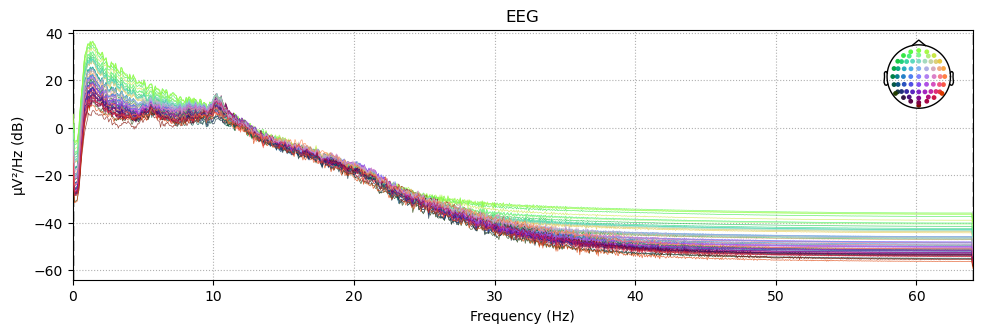

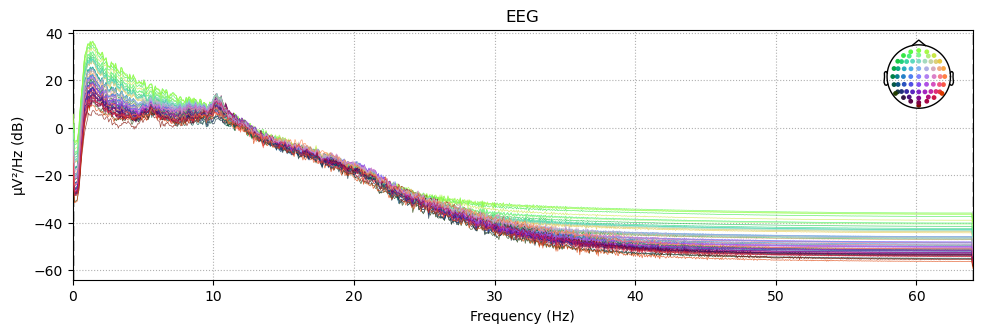

In [5]:
raw.info['bads'] = [] 
#check psd
mne.viz.plot_raw_psd(raw, fmin = 0, fmax = 64)

In [6]:
ica = ICA(max_iter='auto', random_state=97)
"""
ica.fit(raw)

ica.plot_components()"""

'\nica.fit(raw)\n\nica.plot_components()'

In [7]:
#exclude components based on correlation to eog
#eog_indices, eog_scores = ica.find_bads_eog(raw)
#ica.exclude = eog_indices

#manually select components if eog not available
#ica.exclude = [0, 3]

#reconstruct raw
reconst_raw = raw.copy()
#ica.apply(reconst_raw)

In [8]:
events_arr = make_raw_events(events_sv)

In [9]:
def find_keystrokes_others(raw, t_keystrokes, timeframes):
    """ 
    Finds the keystrokes that fall into a certain condition.
    raw: EEG data
    t_keystrokes: all keystroke events
    timeframes: the times of the condition you want, found with find_sections

    Example: find_keystrokes(raw, t_keystrokes, norm_times)
    """
    keystrokes = t_keystrokes[:,0]
    filt_keystrokes = []
    for segment in timeframes:
        start = segment[0]
        end = segment[1]

        condition = (keystrokes >= start) & (keystrokes <= end)
        segment_keystrokes = keystrokes[condition]
        
        # Skip the first keystroke in the current segment
        if len(segment_keystrokes) > 1:
            segment_keystrokes = segment_keystrokes[1:]
        
        filt_keystrokes.extend(segment_keystrokes)

    indices = np.where(np.isin(t_keystrokes[:, 0], filt_keystrokes))[0]
    filt_keystrokes_events = t_keystrokes[indices]
    return filt_keystrokes_events

In [10]:
#              SEGMENT INTO EPOCHS
#--------------------------------------------

# TIMES FOR CROPPING ERPs
erp_begin = -0.2
erp_end = 0.5

plot = True
#--------------------------------------------
#               SET UP TRIGGERS
#--------------------------------------------
events_arr = make_raw_events(events_sv)

if keystroke_trigs == 'MIDI':
    t_keystrokes = clean_triggers(events_arr[events_arr[:, 2]==6])
else:
    t_keystrokes = clean_triggers(events_arr[events_arr[:, 2]==2])

t_inv = clean_triggers(events_arr[events_arr[:, 2]==3])
t_shinv = clean_triggers(events_arr[events_arr[:, 2]==4])
t_norm = clean_triggers(events_arr[events_arr[:, 2]==5])
t_modeswitch = np.concatenate([t_inv, t_shinv, t_norm])
t_modeswitch = events_inorder(t_modeswitch)


#keystrokes for keystrokes after map change and other keystrokes
first_keystrokes = mapchange_keystrokes(t_modeswitch = t_modeswitch, t_keystroke=t_keystrokes)
other_keystrokes = withinmap_keystrokes(t_keystrokes, first_keystrokes)

Not setting metadata
359 matching events found
Setting baseline interval to [-0.203125, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 359 events and 91 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
182 matching events found
Setting baseline interval to [-0.203125, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 182 events and 91 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
82 matching events found
Setting baseline interval to [-0.203125, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 82 events and 91 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New co

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_67756/1408391084.py:7: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  epochs = epochs.copy().interpolate_bads(reset_bads = True)
/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/../utils/pp_utils.py:290: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  epochs_mode = epochs_mode.copy().interpolate_bads(reset_bads = True)
/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/../utils/pp_utils.py:290: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  epochs_mode = epochs_mode.copy().interpolate_bads(reset_bads = True)
/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/../utils/pp_utils.py:290: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  epochs_mode = epochs_mode.copy().interpolate_bads(reset_bads = True)
/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/../utils/pp_utils.py:290: 

0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/../utils/pp_utils.py:290: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  epochs_mode = epochs_mode.copy().interpolate_bads(reset_bads = True)


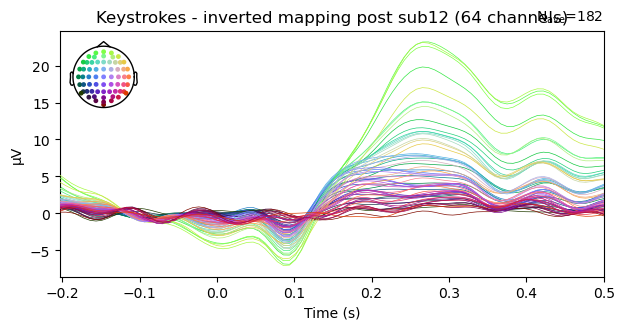

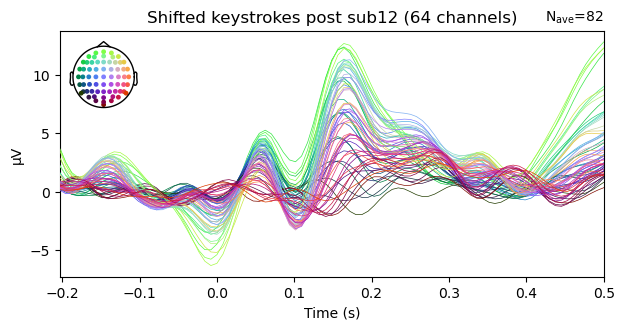

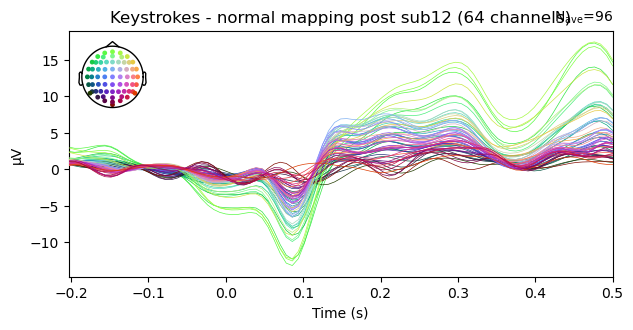

In [17]:


#--------------------------------------------
#               SET UP EVOKEDS OBJECTS
#--------------------------------------------

#all epochs
epochs = mne.Epochs(reconst_raw, t_keystrokes, tmin=erp_begin, tmax=erp_end, preload=True)
epochs = epochs.copy().interpolate_bads(reset_bads = True)
evoked = epochs.average()


#epochs separated by mode
epochs_inv, evoked_inv = epochs_bymode(reconst_raw, t_keystrokes, t_inv, t_modeswitch, erp_begin, erp_end)
epochs_shinv, evoked_shinv = epochs_bymode(reconst_raw, t_keystrokes, t_shinv, t_modeswitch, erp_begin, erp_end)
epochs_norm, evoked_norm = epochs_bymode(reconst_raw, t_keystrokes, t_norm, t_modeswitch, erp_begin, erp_end)


#epochs separated by whether it is immediately after a map change or not
epochs_firsts, evoked_firsts  = construct_ep_ev(reconst_raw, first_keystrokes, erp_begin, erp_end)
epochs_others, evoked_others = construct_ep_ev(reconst_raw, other_keystrokes, erp_begin, erp_end)

if plot:
    fig = evoked_inv.plot(titles = f'Keystrokes - inverted mapping {period} sub{subject_ID}')
    fig = evoked_shinv.plot(titles = f'Shifted keystrokes {period} sub{subject_ID}')
    fig = evoked_norm.plot(titles = f'Keystrokes - normal mapping {period} sub{subject_ID}')


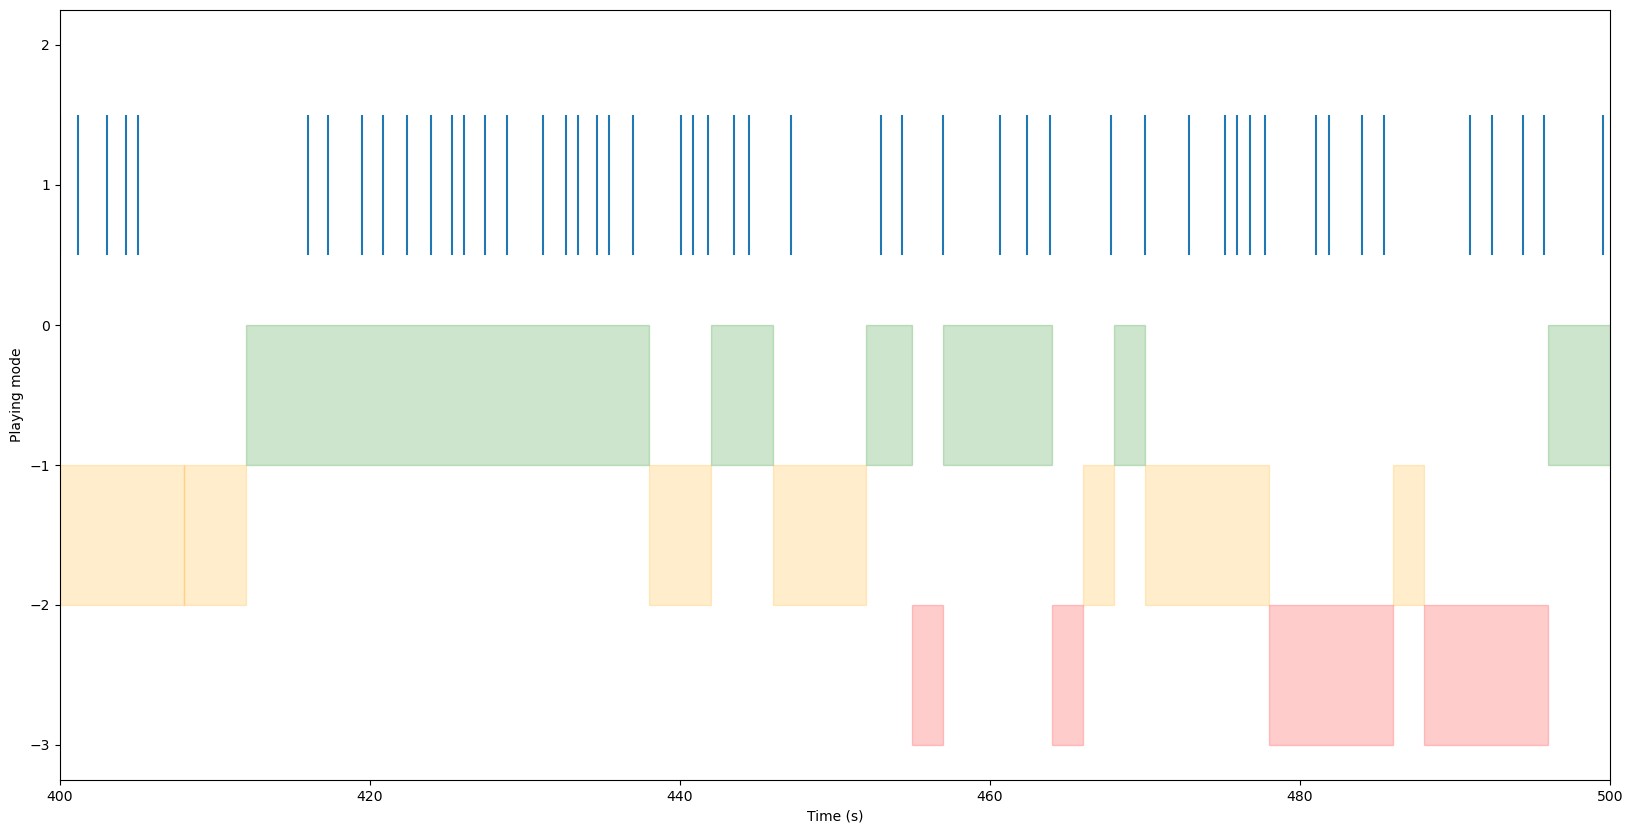

In [16]:
inv_sections = find_sections(reconst_raw, t_inv, t_modeswitch)
shinv_sections = find_sections(reconst_raw, t_shinv, t_modeswitch)
norm_sections = find_sections(reconst_raw, t_norm, t_modeswitch)

all_sections = [
    inv_sections,
    shinv_sections,
    norm_sections
]

plot_sections(section_list=all_sections)
#plt.eventplot(t_keystrokes[:,0]/downfreq)
plt.eventplot(other_keystrokes[:,0]/downfreq)

plt.xlim(400,500)
plt.show()


In [ ]:
overwrite = False

#--------------------------------------------
#         SAVE DATA
#--------------------------------------------
#ERPs
"""mne.write_evokeds(f'{evokeds_folder}/error_ERP_all_{period}_{subject_ID}.fif', evoked, overwrite = overwrite)
mne.write_evokeds(f'{evokeds_folder}/error_ERP_inv_{period}_{subject_ID}.fif', inv_evoked, overwrite = overwrite)
mne.write_evokeds(f'{evokeds_folder}/error_ERP_shinv_{period}_{subject_ID}.fif', shinv_evoked, overwrite = overwrite)
mne.write_evokeds(f'{evokeds_folder}/error_ERP_norm_{period}_{subject_ID}.fif', norm_evoked, overwrite = overwrite)

#epochs
epochs.save(f'{epochs_folder}/error_epochs_all_{period}_{subject_ID}.fif', overwrite = overwrite)
epochs_inv.save(f'{epochs_folder}/error_epochs_inv_{period}_{subject_ID}.fif', overwrite = overwrite)
epochs_shinv.save(f'{epochs_folder}/error_epochs_shinv_{period}_{subject_ID}.fif', overwrite = overwrite)
epochs_norm.save(f'{epochs_folder}/error_epochs_norm_{period}_{subject_ID}.fif', overwrite = overwrite)




"""



"mne.write_evokeds(f'{evokeds_folder}/error_ERP_all_{period}_{subject_ID}.fif', evoked, overwrite = overwrite)\nmne.write_evokeds(f'{evokeds_folder}/error_ERP_inv_{period}_{subject_ID}.fif', inv_evoked, overwrite = overwrite)\nmne.write_evokeds(f'{evokeds_folder}/error_ERP_shinv_{period}_{subject_ID}.fif', shinv_evoked, overwrite = overwrite)\nmne.write_evokeds(f'{evokeds_folder}/error_ERP_norm_{period}_{subject_ID}.fif', norm_evoked, overwrite = overwrite)\n\n#epochs\nepochs.save(f'{epochs_folder}/error_epochs_all_{period}_{subject_ID}.fif', overwrite = overwrite)\nepochs_inv.save(f'{epochs_folder}/error_epochs_inv_{period}_{subject_ID}.fif', overwrite = overwrite)\nepochs_shinv.save(f'{epochs_folder}/error_epochs_shinv_{period}_{subject_ID}.fif', overwrite = overwrite)\nepochs_norm.save(f'{epochs_folder}/error_epochs_norm_{period}_{subject_ID}.fif', overwrite = overwrite)\n\n\n\n\n"